### Train NNs on the toy example

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from sklearn.model_selection import train_test_split
import dama as dm
import pickle
import os
from tqdm import tqdm

from freedom.toy_model.toy_model_functions import toy_model
from freedom.toy_model.detectors import get_box_detector
from types import SimpleNamespace

%load_ext autoreload
%autoreload 2

In [46]:
from freedom.toy_model import NNs
%aimport freedom.toy_model.NNs

import awkward as ak
import pyarrow.parquet as pq
import json

from freedom.toy_model.NNs import hit_trafo_3D, charge_trafo_3D

In [2]:
from batty import BAT_sampler, BAT, Distributions

/home/iwsatlas1/peller/batty/batty.py:6: UserWarning: Not able to use compiled modules, resulting in (very) slow import
 See https://pyjulia.readthedocs.io/en/latest/troubleshooting.html
  warnings.warn("Not able to use compiled modules, resulting in (very) slow import\n See https://pyjulia.readthedocs.io/en/latest/troubleshooting.html")


In [3]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [4]:
detector = get_box_detector(x=np.linspace(-20,20,5), y=np.linspace(-20,20,5), z=np.linspace(-20,20,5))

In [5]:
toy_experiment = toy_model(detector)

In [6]:
truth = np.array([2., 3, 1, 0, 2, 1, 20, 0.9])
rand = np.random.RandomState(0)
test_event = toy_experiment.generate_event(truth, rand=rand)

In [7]:
g = dm.GridData(x=np.linspace(-5, 5, 100), y=np.linspace(0, 4, 100))

In [8]:
toy_experiment.calc_analytic_llhs(g, test_event, truth);

10000it [00:37, 269.71it/s]


In [9]:
def plot_truth(axes, truth):
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    for ax in axes.flatten():
        ax.plot([truth[0]], [truth[1]], marker='$T$', markersize=10, color='k')

In [10]:
def plot_diff(a, b, axes, title_a='a', title_b='b', vmax=None, limit_diff=False, **kwargs):
    
    levels = stats.chi2(df=2).isf(stats.norm.sf(np.arange(1,6))*2)/2    
    labels = [str(i) + r'$\sigma$' for i in range(1,6)]
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    colors = plt.cm.viridis(np.linspace(0, 0.9, 6))
    #a.plot(ax=axes[0], cmap='binary', label=r'$\Delta LLH$', vmax=vmax, **kwargs)
    a.plot_contour(ax=axes[0], levels=levels, labels=labels, colors=colors, **kwargs)
    axes[0].set_title(title_a)
    #b.plot(ax=axes[1], cmap='binary', label=r'$\Delta LLH$', vmax=vmax, **kwargs)
    b.plot_contour(ax=axes[1], levels=levels,  labels=labels, colors=colors, **kwargs)
    axes[1].set_title(title_b)
    
    if len(axes) > 2:
        diff = a - b
        if limit_diff:
            diff.plot(ax=axes[2], cmap='RdBu', cbar=True, vmin=-vmax, vmax=vmax, label=r'$\Delta LLH$', **kwargs)
            #diff.plot_contour(ax=axes[2], levels=levels, labels=labels, colors=colors, label=r'$\Delta LLH$', **kwargs)
            #np.clip(-diff, 0, None).plot_contour(ax=axes[2], levels=[0.1,0.2, 0.3], colors=['r']*2)
        else:
            diff.plot(ax=axes[2], cmap='RdBu', cbar=True, vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)), label=r'$\Delta LLH$', **kwargs) 
            #diff.plot_contour(ax=axes[2], levels=levels, labels=labels, colors=colors, label=r'$\Delta LLH$', **kwargs)
        axes[2].set_title(title_a + ' - ' + title_b)

Text(0.5, 0, 'x (m)')

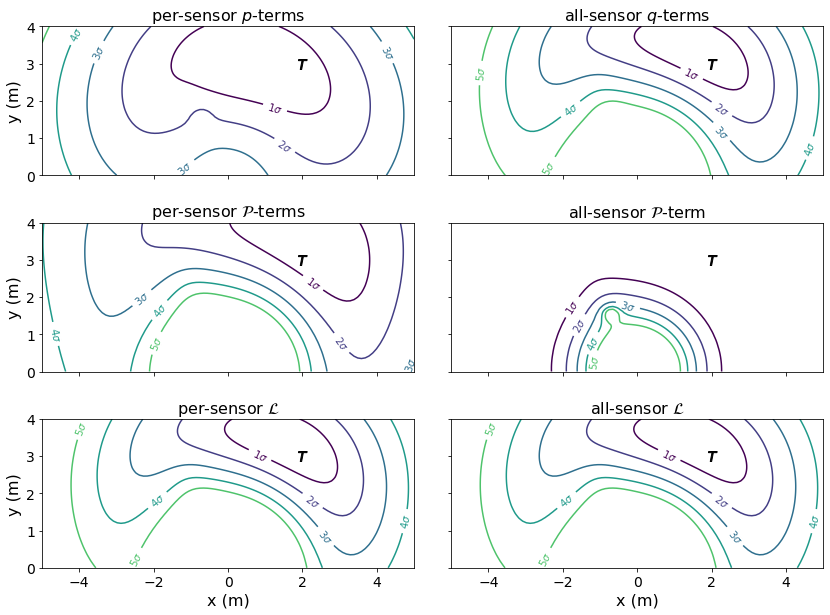

In [11]:
fig, ax = plt.subplots(3, 2, figsize=(14,10), sharex=True, sharey=True)

for axis in ax.flatten():
    axis.set_aspect("equal")

plt.subplots_adjust(wspace=0.1, hspace=0.3)

plot_diff(g['per_dom_hit_term'], g['all_dom_charge_hit_terms'], axes=ax[0], title_a=r'per-sensor $p$-terms', title_b=r'all-sensor $q$-terms', vmax=100, limit_diff=True)
plot_diff(g['per_dom_charge_terms'], g['all_dom_charge_terms'], axes=ax[1], title_a='per-sensor $\mathcal{P}$-terms', title_b=r'all-sensor $\mathcal{P}$-term', vmax=100, limit_diff=True)
plot_diff(g['per_dom_llh'], g['all_dom_charge_llh'], axes=ax[2], title_a=r'per-sensor $\mathcal{L}$', title_b=r'all-sensor $\mathcal{L}$', limit_diff=False, vmax=100)

plot_truth(ax, truth)

ax[0,0].set_xlabel('')
ax[1,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[1,1].set_xlabel('')
[ax[i,1].set_ylabel('') for i in range(3)];
[ax[i,0].set_ylabel('y (m)') for i in range(3)];
ax[2,0].set_xlabel('x (m)')
ax[2,1].set_xlabel('x (m)')


#plt.savefig('sensor_vs_global.pdf', bbox_inches='tight')
#plt.savefig('sensor_vs_global.png', bbox_inches='tight')

## Generate Events

In [38]:
events, meta = toy_experiment.generate_events(n=1_000_000,
                               gamma=0,
                               gen_volume="box",
                               e_lim=(5,100),
                               x_lim=(-30,30),
                               y_lim=(-30,30),
                               z_lim=(-30,30),
                               inelast_lim=(0,1),
                               t_width=0,
                               contained=True,
                               N_min=3,
                               rand=0,
                               outfile='1M_toy_events.parquet')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [13:07<00:00, 1269.90it/s]


In [183]:
events = ak.from_parquet('1M_toy_events.parquet')

In [184]:
json.loads(pq.read_schema('1M_toy_events.parquet').metadata['gen_config'.encode()].decode())

{'rand': 0,
 'gen_volume': 'box',
 'x_lim': [-30, 30],
 'y_lim': [-30, 30],
 'z_lim': [-30, 30],
 'n': 1000000,
 'outfile': '1M_8d_toy_events_min3_gamma0.parquet',
 'gamma': 0,
 'e_lim': [5, 100],
 'inelast_lim': [0, 1],
 't_width': 0,
 'N_min': 3,
 'contained': True}

In [185]:
c = events.n_obs.to_numpy()

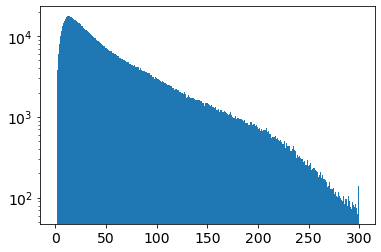

In [186]:
plt.hist(ak.count(events.photons.t, axis=1).to_numpy(), bins=np.linspace(0,300,300));
plt.gca().set_yscale("log")

# Train NNs

## Hit Net

In [187]:
x, t = NNs.get_hit_data(events)
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.1, random_state=42)
d_train = NNs.DataGenerator(x_train, t_train, batch_size=4096)
d_valid = NNs.DataGenerator(x_test, t_test, batch_size=4096)

In [191]:
optimizer = tf.keras.optimizers.Adam(1e-4)

hmodel = NNs.get_hmodel(x_shape=x.shape[1], t_shape=t.shape[1], trafo=NNs.hit_trafo_3D, activation='swish')

hmodel.compile(loss='binary_crossentropy', optimizer=optimizer)

In [192]:
hist = hmodel.fit(d_train, epochs=4, verbose=1, validation_data=d_valid)

Epoch 1/4
27539/27539 [==============================] - 248s 9ms/step - loss: 0.3996 - val_loss: 0.3946
Epoch 2/4
27539/27539 [==============================] - 236s 9ms/step - loss: 0.3920 - val_loss: 0.3916
Epoch 3/4
27539/27539 [==============================] - 235s 9ms/step - loss: 0.3910 - val_loss: 0.3908
Epoch 4/4
27539/27539 [==============================] - 240s 9ms/step - loss: 0.3903 - val_loss: 0.3899


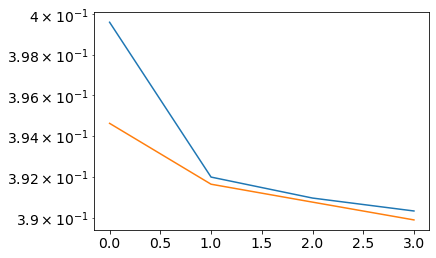

In [193]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.yscale('log')

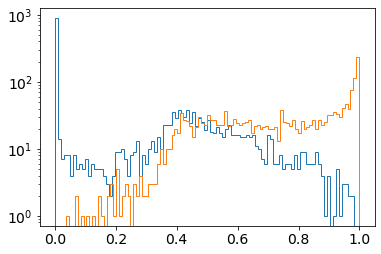

In [194]:
inp, lab = d_valid.__getitem__(0)
pred = hmodel.predict(inp, batch_size=4096).flatten()
plt.hist(pred[lab==0], 100, histtype='step')
plt.hist(pred[lab==1], 100, histtype='step');
plt.yscale('log')

In [195]:
hmodel.save('networks/deepcore_toy_hitnet_total.h5')

In [196]:
hitnet = tf.keras.models.clone_model(hmodel)
hitnet.layers[-1].activation = tf.keras.activations.linear
hitnet.compile()
hitnet.set_weights(hmodel.get_weights())

## Charge Net

In [198]:
x, t = NNs.get_charge_data(events)
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.1, random_state=42)

d_train = NNs.DataGenerator(x_train, t_train, batch_size=4096)
d_valid = NNs.DataGenerator(x_test, t_test, batch_size=4096)

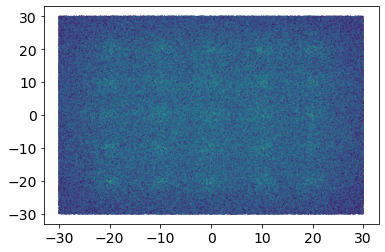

In [199]:
plt.scatter(t_train[:,0], t_train[:,1], s=0.1, c=np.log(x_train[:,0]))

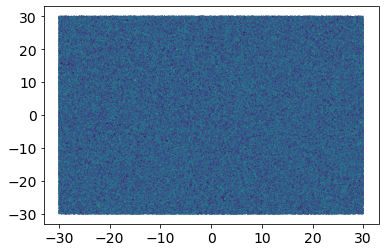

In [200]:
plt.scatter(t_train[:,0], t_train[:,1], s=0.1, c=np.log(np.random.permutation(x_train[:,0])))

In [202]:
cmodel = NNs.get_cmodel(x_shape=x.shape[1], t_shape=t.shape[1], trafo=NNs.charge_trafo_3D, activation='swish', final_activation='swish') #, n_layers=16, n_nodes=128)

In [203]:
optimizer = tf.keras.optimizers.Adam(1e-3)
cmodel.compile(loss='binary_crossentropy', optimizer=optimizer)

In [204]:
hist = cmodel.fit(d_train, epochs=100, verbose=1, validation_data=d_valid)

Epoch 1/100
439/439 [==============================] - 4s 8ms/step - loss: 0.3650 - val_loss: 0.3201
Epoch 2/100
439/439 [==============================] - 3s 8ms/step - loss: 0.3136 - val_loss: 0.3065
Epoch 3/100
439/439 [==============================] - 3s 8ms/step - loss: 0.3019 - val_loss: 0.2959
Epoch 4/100
439/439 [==============================] - 3s 7ms/step - loss: 0.2985 - val_loss: 0.2944
Epoch 5/100
439/439 [==============================] - 3s 7ms/step - loss: 0.2960 - val_loss: 0.2949
Epoch 6/100
439/439 [==============================] - 3s 8ms/step - loss: 0.2940 - val_loss: 0.2961
Epoch 7/100
439/439 [==============================] - 3s 8ms/step - loss: 0.2922 - val_loss: 0.2889
Epoch 8/100
439/439 [==============================] - 3s 8ms/step - loss: 0.2916 - val_loss: 0.2939
Epoch 9/100
439/439 [==============================] - 3s 8ms/step - loss: 0.2899 - val_loss: 0.2892
Epoch 10/100
439/439 [==============================] - 3s 8ms/step - loss: 0.2885 - val_lo

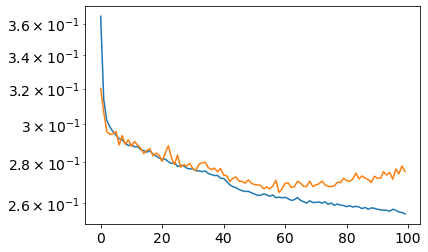

In [205]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.yscale('log')

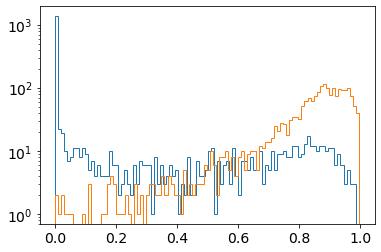

In [206]:
inp, lab = d_valid.__getitem__(0)
pred = cmodel.predict(inp, batch_size=4096).flatten()
plt.hist(pred[lab==0], 100, histtype='step')
plt.hist(pred[lab==1], 100, histtype='step');
plt.yscale('log')

In [207]:
cmodel.save('networks/deepcore_toy_chargenet_total.h5')

In [208]:
chargenet = tf.keras.models.clone_model(cmodel)
chargenet.set_weights(cmodel.get_weights())
chargenet.layers[-1].activation = tf.keras.activations.linear
chargenet.compile()

In [209]:
def plot_overlay(a, b, ax, **kwargs):
    levels = stats.chi2(df=2).isf(stats.norm.sf(np.arange(1,6))*2)/2    
    labels = [str(i) + r'$\sigma$' for i in range(1,6)]
    colors = plt.cm.viridis(np.linspace(0, 0.9, 6))
    a.plot_contour(ax=ax, levels=levels, labels=labels, colors=colors, **kwargs)
    b.plot_contour(ax=ax, levels=levels,  linestyles=[':']*len(levels), colors=colors, **kwargs)


In [210]:
g = dm.GridData(x=np.linspace(-25, 25, 100), y=np.linspace(-25, 25, 100))

In [211]:
toy_experiment.calc_analytic_llhs(g, test_event, truth);

10000it [00:29, 336.62it/s]


In [220]:
toy_experiment.calc_NN_llhs(g, test_event, truth, chargenet, hitnet);

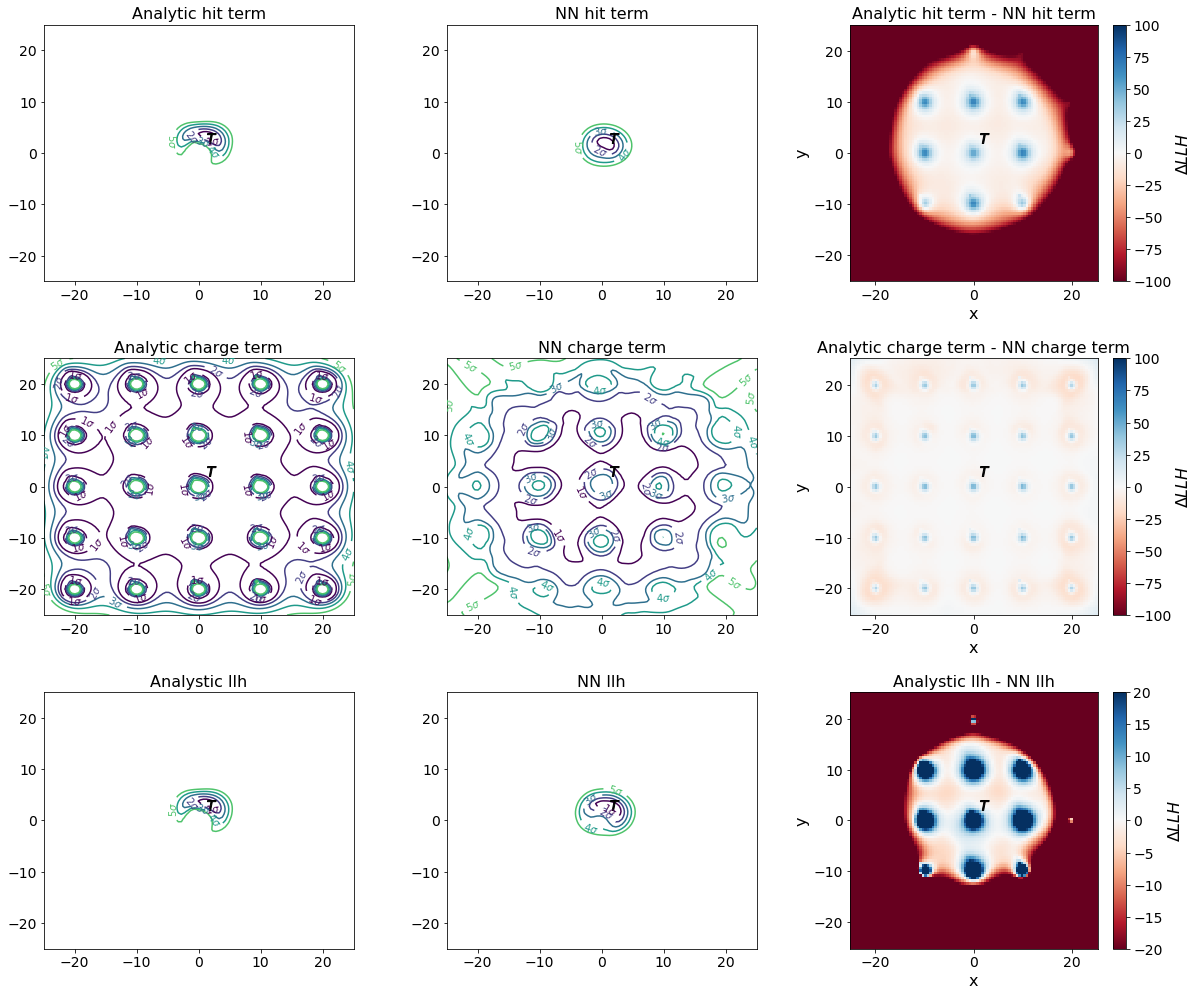

In [221]:
fig, ax = plt.subplots(3, 3, figsize=(20,17))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plot_diff(g['all_dom_charge_hit_terms'], g.hitnet_llh, axes=ax[0], title_a='Analytic hit term', title_b='NN hit term', vmax=100, limit_diff=True)
plot_diff(g['all_dom_charge_terms'], g.chargenet_llh, axes=ax[1], title_a='Analytic charge term', title_b='NN charge term', vmax=100, limit_diff=True)
plot_diff(g.all_dom_charge_llh, g.freedom_llh, axes=ax[2], title_a='Analystic llh', title_b='NN llh', vmax=20, limit_diff=True)

plot_truth(ax, truth)

In [523]:
g = dm.GridData(e_trck = np.linspace(1,30,100))
toy_experiment.calc_analytic_llhs(g, test_event, truth);
toy_experiment.calc_NN_llhs(g, test_event, truth, chargenet, hitnet);

100it [00:00, 141.79it/s]


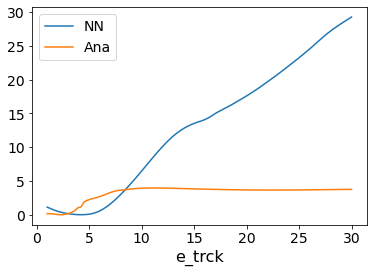

In [525]:
g.freedom_llh.plot(label='NN')
g.all_dom_charge_llh.plot(label='Ana')
plt.legend()

In [526]:
g = dm.GridData(e_trck = np.linspace(1,30,100), e_cscd=np.linspace(1,30,100))
toy_experiment.calc_analytic_llhs(g, test_event, truth);
toy_experiment.calc_NN_llhs(g, test_event, truth, chargenet, hitnet);

10000it [01:12, 137.15it/s]


Text(0.5, 1.0, 'Ana')

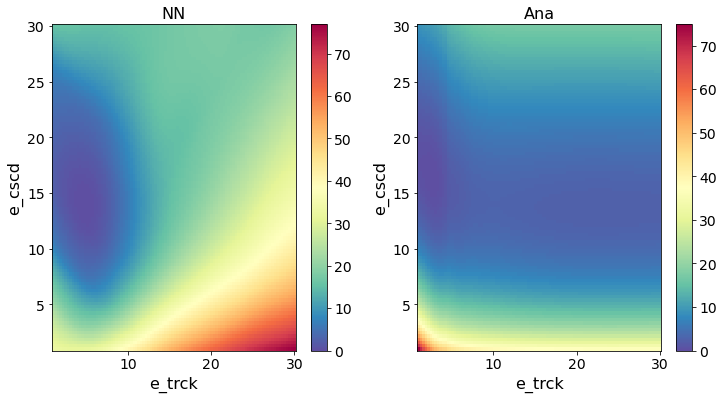

In [536]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

g.freedom_llh.plot(ax=ax[0], cmap=plt.cm.Spectral_r, cbar=True)
g.all_dom_charge_llh.plot(ax=ax[1], cmap=plt.cm.Spectral_r, cbar=True)

ax[0].set_title('NN')
ax[1].set_title('Ana')

In [557]:
toy_experiment.model(2.,  3.,  1.,  0.,  2.,  1., 0.,  20)[:, 3]

array([  0.        ,   3.33333333,   6.66666667,  10.        ,
        13.33333333,  16.66666667,  20.        ,  23.33333333,
        26.66666667,  30.        ,  33.33333333,  36.66666667,
        40.        ,  43.33333333,  46.66666667,  50.        ,
        53.33333333,  56.66666667,  60.        ,  63.33333333,
        66.66666667,  70.        ,  73.33333333,  76.66666667,
        80.        ,  83.33333333,  86.66666667,  90.        ,
        93.33333333,  96.66666667, 100.        , 103.33333333,
       106.66666667, 110.        , 113.33333333, 116.66666667,
       120.        , 123.33333333, 126.66666667, 130.        ,
       133.33333333, 136.66666667, 140.        , 143.33333333,
       146.66666667, 150.        , 153.33333333, 156.66666667,
       160.        , 163.33333333, 166.66666667, 170.        ,
       173.33333333, 176.66666667, 180.        , 183.33333333,
       186.66666667, 190.        , 193.33333333, 196.66666667,
       200.        , 203.33333333, 206.66666667, 210.  

# MCMCcbar

In [515]:

hitnet = tf.keras.models.load_model('networks/deepcore_toy_hitnet_total.h5',
                                 custom_objects={'hit_trafo_3D':NNs.hit_trafo_3D})
hitnet.layers[-1].activation = tf.keras.activations.linear
hitnet.compile()

chargenet = tf.keras.models.load_model('networks/deepcore_toy_chargenet_total.h5',
                                 custom_objects={'charge_trafo_3D':NNs.charge_trafo_3D})
chargenet.layers[-1].activation = tf.keras.activations.linear
chargenet.compile()

In [382]:
def llh(p, test_event, chargenet, hitnet):
    xxs = np.array([np.sum(test_event[1]), np.sum(test_event[1]>0)])[np.newaxis, :]
    tts = p[np.newaxis, :]
    c_llh = chargenet((xxs, tts))[0,0].numpy()

    xxs = test_event[0]
    tts = np.repeat(p[np.newaxis, :], len(test_event[0]), axis=0)
    h_llhs = hitnet((xxs, tts)).numpy()
    h_llh = np.nan_to_num(np.sum(h_llhs))

    return c_llh + h_llh

In [383]:
priors = {}
priors['x'] = Distributions.Uniform(-25, 25)
priors['y'] = Distributions.Uniform(-25, 25)
priors['z'] = Distributions.Uniform(-25, 25)
priors['az'] = Distributions.Uniform(0, 2*np.pi)
priors['zen'] = Distributions.Uniform(0, np.pi)
priors['e'] = Distributions.Uniform(5,100)
priors['inelast'] = Distributions.Uniform(0,1)

In [409]:
def bat_llh_ana(x):
    p = np.copy(truth)
    p[0] = x.x
    p[1] = x.y
    p[2] = x.z
    p[4] = x.az
    p[5] = x.zen
    p[6] = x.e * x.inelast
    p[7] = x.e * (1 - x.inelast)
    l = -toy_experiment.nllh(p, *test_event)
    #print(l)
    return l

In [410]:
def bat_llh(x):
    p = np.copy(truth)
    p[0] = x.x
    p[1] = x.y
    p[2] = x.z
    p[4] = x.az
    p[5] = x.zen
    p[6] = x.e * x.inelast
    p[7] = x.e * (1 - x.inelast)
    l = llh(p, test_event, chargenet, hitnet)
    #print(l)
    return l

In [324]:
from collections import namedtuple

In [411]:
p_type = namedtuple('p', ['x', 'y', 'z', 'az', 'zen', 'e', 'inelast'])
test_p = p_type(x=0, y=0, z=0, az=0, zen=0, e=10, inelast=0)

In [412]:
bat_llh(test_p)

-34.689507

In [421]:
bat_llh_ana(test_p)

-1070.0602340352332

In [422]:
%load_ext line_profiler

In [440]:
from scipy.special import hyp1f1, gamma

In [443]:
%%timeit
hyp1f1(1,1,1)

2.67 µs ± 45.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [444]:
%%timeit
gamma(2)

1.13 µs ± 6.26 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [441]:
%lprun -f gamma bat_llh_ana(test_p)

/home/iwsatlas1/peller/.local/lib/python3.9/site-packages/line_profiler/line_profiler.py:344: UserWarning: Could not extract a code object for the object <ufunc 'gamma'>
  profile = LineProfiler(*funcs)


Timer unit: 1e-06 s

In [389]:
sampler = BAT_sampler(bat_llh, priors)

In [414]:
sampler_ana = BAT_sampler(bat_llh_ana, priors)

In [ ]:
%%time
sampler.run(nsteps=1e5, nchains=5);

[ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
[ Info: Using transform algorithm BAT.PriorSubstitution()
[ Info: Trying to generate 5 viable MCMC chain(s).


In [415]:
%%time
sampler_ana.run(nsteps=1e5, nchains=5);

[ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
[ Info: Using transform algorithm BAT.PriorSubstitution()
[ Info: Trying to generate 5 viable MCMC chain(s).
[ Info: Selected 5 MCMC chain(s).
[ Info: Begin tuning of 5 MCMC chain(s).
[ Info: MCMC Tuning cycle 1 finished, 5 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 2 finished, 5 chains, 2 tuned, 0 converged.
[ Info: MCMC Tuning cycle 3 finished, 5 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 4 finished, 5 chains, 0 tuned, 5 converged.
[ Info: MCMC Tuning cycle 5 finished, 5 chains, 2 tuned, 5 converged.
[ Info: MCMC Tuning cycle 6 finished, 5 chains, 3 tuned, 5 converged.
[ Info: MCMC Tuning cycle 7 finished, 5 chains, 4 tuned, 5 converged.
[ Info: MCMC Tuning cycle 8 finished, 5 chains, 5 tuned, 5 converged.
[ Info: MCMC tuning of 5 chains successful after 8 cycle(s).
[ Info: Running post-tuning stabilization steps for 5 MCMC chain(s).


CPU times: user 2h 53min 29s, sys: 2min 38s, total: 2h 56min 8s
Wall time: 2h 55min 56s


BAT_result(samples=result_tuple(x=array([2.43445418, 1.88042825, 2.45728095, ..., 2.62421012, 2.18469753,
       1.92287762]), y=array([0.34672302, 0.5004267 , 0.51101853, ..., 0.3721268 , 0.83363594,
       0.99889629]), z=array([-1.81740765, -1.32092226, -0.54307927, ..., -0.22753827,
       -0.26958595, -0.25242449]), az=array([5.02028511, 4.70254618, 4.61866069, ..., 5.78720223, 5.68511015,
       5.52526874]), zen=array([2.1336704 , 2.03771912, 2.04169596, ..., 1.94831564, 1.90669452,
       2.02282635]), e=array([66.74998688, 69.69711824, 80.41414215, ..., 20.10859483,
       16.71153682, 14.76024314]), inelast=array([0.00396079, 0.00466221, 0.00299208, ..., 0.006761  , 0.00381858,
       0.00403852])), weight=array([ 9.,  2.,  2., ...,  1.,  7., 14.]), logd=array([-194.97609125, -196.19555361, -196.04191038, ..., -200.88456924,
       -199.48248801, -198.69552702]))

In [417]:
sampler_ana.result.samples

result_tuple(x=array([2.43445418, 1.88042825, 2.45728095, ..., 2.62421012, 2.18469753,
       1.92287762]), y=array([0.34672302, 0.5004267 , 0.51101853, ..., 0.3721268 , 0.83363594,
       0.99889629]), z=array([-1.81740765, -1.32092226, -0.54307927, ..., -0.22753827,
       -0.26958595, -0.25242449]), az=array([5.02028511, 4.70254618, 4.61866069, ..., 5.78720223, 5.68511015,
       5.52526874]), zen=array([2.1336704 , 2.03771912, 2.04169596, ..., 1.94831564, 1.90669452,
       2.02282635]), e=array([66.74998688, 69.69711824, 80.41414215, ..., 20.10859483,
       16.71153682, 14.76024314]), inelast=array([0.00396079, 0.00466221, 0.00299208, ..., 0.006761  , 0.00381858,
       0.00403852]))

In [82]:
from corner import corner

In [259]:
sampler.result.samples._fields

('x', 'y', 'z', 'az', 'zen', 'e', 'inelast')

In [267]:
labels = ['x (m)', 'y (m)', 'z (m)', r'Azimuth (rad)', r'Zenith (rad)', 'Energy (GeV)', 'Inelasticity']

In [394]:
truth

array([ 2.,  3.,  1.,  0.,  2.,  1., 18.,  2.])

In [395]:
true_vals = np.copy(truth)[:7]

In [396]:
true_vals[3:7] = truth[4:]

In [400]:
true_vals[-2] = 20
true_vals[-1] = 0.9

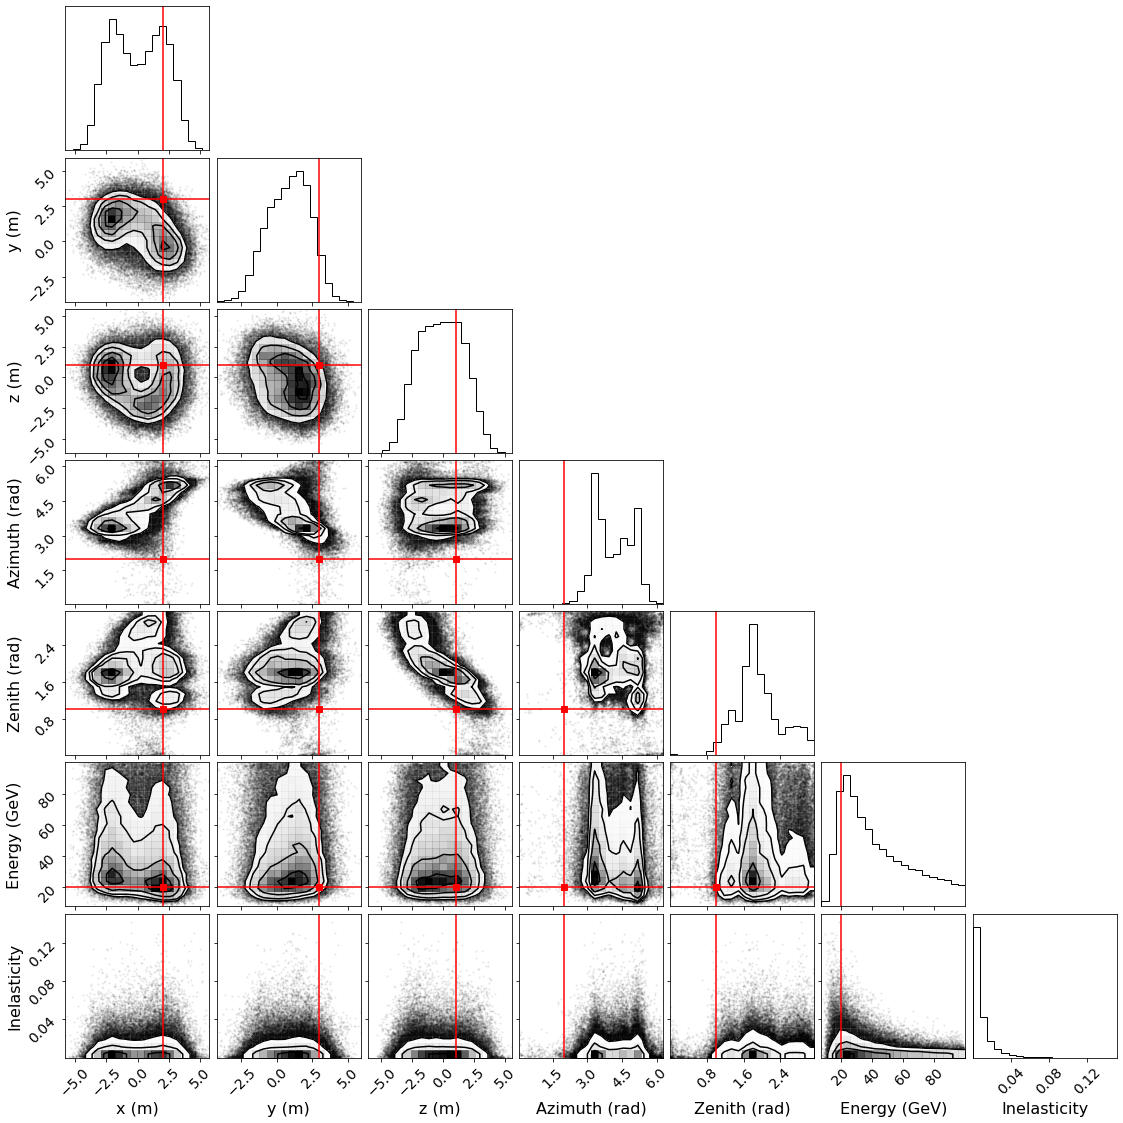

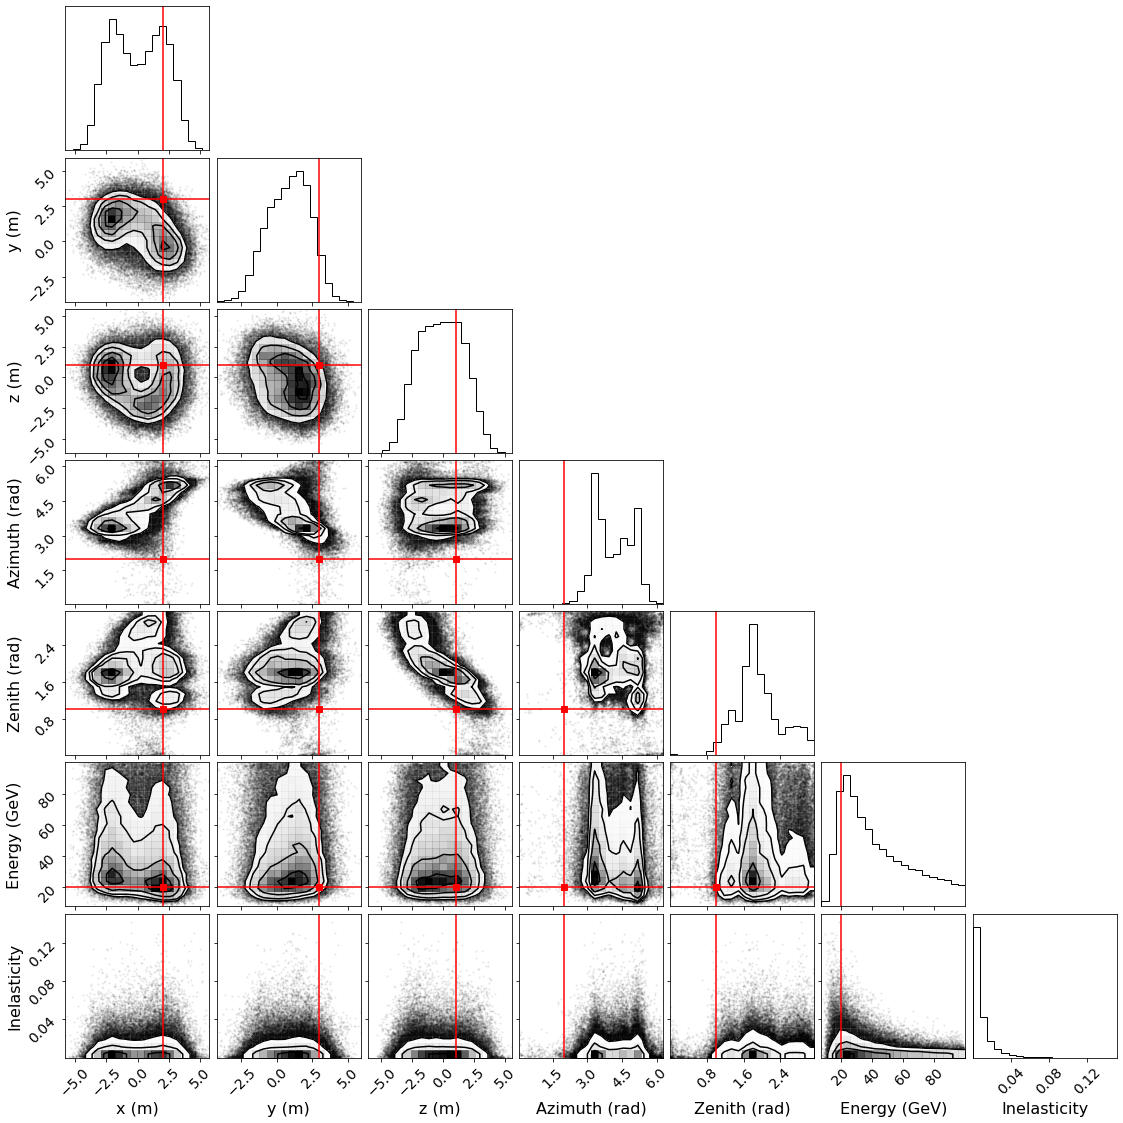

In [418]:
corner(np.stack(sampler_ana.result.samples).T, labels=labels, weights=sampler_ana.result.weight, truths=true_vals, truth_color='r')
#plt.savefig('MCMC_7d_test.jpg')

In [270]:
import pygtc

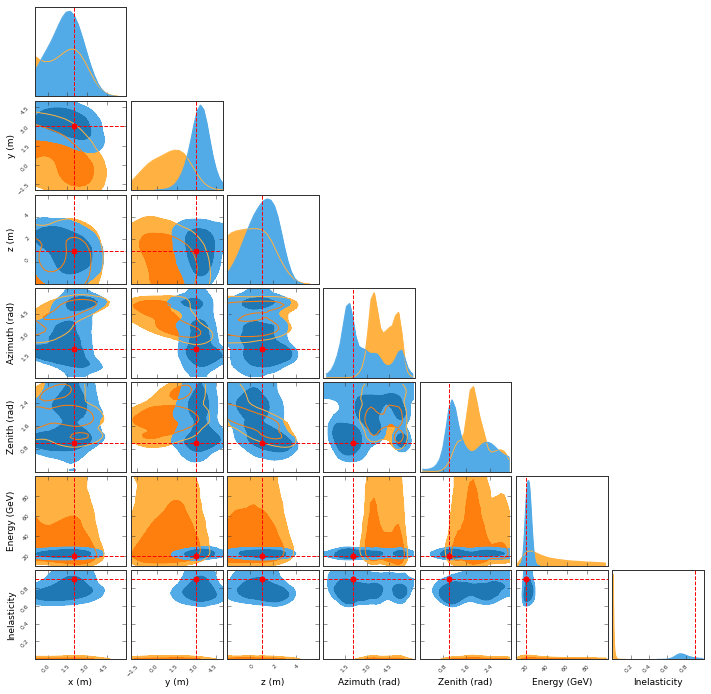

In [419]:
fig = pygtc.plotGTC(chains=[np.stack(sampler.result.samples).T, np.stack(sampler_ana.result.samples).T], truthColors='r',
              weights=[sampler.result.weight, sampler_ana.result.weight],
              paramNames=labels,
              truths=true_vals,
              figureSize=12,
              nContourLevels=2,
              paramRanges=[(-1, 6), (-2, 5), (-2, 6), (0, 2*np.pi), (0, np.pi), (10, 100), (0, 1)],
              panelSpacing='loose')

mod = 1
m = 0
i = 0
for n in range(len(fig.axes)-7):
    j = m % mod
    fig.axes[n].plot(true_vals[j], true_vals[i+1], '.', ms=10, c=c)
    if j == mod - 1:
        mod += 1
        m = 0
        i += 1
    else:
        m += 1
#fig.savefig('MCMC_7d_test_kde.jpg', dpi=200, bbox_inches='tight')